In [109]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-12-20 10:26


In [110]:
import json
import glob
import os

from tqdm import tqdm

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from matplotlib import cm
import seaborn as sns

The reviews made it obvious that comparison of functional equivalence between pairs of proteins often are carried out on the level of GO terms. Therefore, we decided to conduct different analyses on GO terms, comparing the annotations of proteins given by structural or sequence similarity.

First we will solely compare the GO-term assignments between strucural and sequence based annotations:

In [111]:
structural_annotation = pd.read_parquet('/g/arendt/npapadop/repos/coffe/data/structure_annotation.parquet')
sequence_annotation = pd.read_csv('/g/arendt/npapadop/repos/coffe/data/Slacustris_eggnog.tsv', sep='\t')

In [112]:
annotations_complete = structural_annotation[['protein_id', 'eggNOG_OGs', 'MSA size','alignment length', 'query length', 'seq. id.', 'bit score','plddt', 'complete_protein', "Preferred_name", "Description", "GOs"]].merge(sequence_annotation[['protein_id', 'eggNOG_OGs', 'score', "Preferred_name", "Description", "GOs"]], 
                                                                           on='protein_id', suffixes=['_struct', '_seq'], how = 'outer')

## Comparison of GO-terms between structural (MorF) and sequence based (EggNOG) annotation

In [113]:
GO_struct_missing = annotations_complete['GOs_struct'] == '-'
GO_struct_isnan = annotations_complete['GOs_struct'].isnull()

GO_seq_missing = annotations_complete['GOs_seq'] == '-'
GO_seq_isnan = annotations_complete['GOs_seq'].isnull()

GO_struct_avail = ~(GO_struct_missing | GO_struct_isnan)
GO_seq_avail = ~(GO_seq_missing | GO_seq_isnan)

In [114]:
annotations_GOs = annotations_complete[GO_struct_avail & GO_seq_avail]

Now that we have all cases in which structure and sequence annotations actually produce GO-terms, we can compare the overlap between those annotations on the level of GO-terms.

There will be a couple of different levels:

    - Complete overlap (GO terms are identical)
    - Partial overlap:
        - Unique GO-terms on both sides ('unique GOs')
        - All structure GO-terms in sequence GO-terms ('Sequence GOs expanded')
        - All sequence GO-terms in structure GO-terms ('Structure GOs expanded')
    - No overlap

In [115]:
GOs = annotations_GOs[['GOs_struct', 'GOs_seq']]

In [116]:
GOs['GOs_struct'] = GOs['GOs_struct'].str.split(',')
GOs['GOs_seq'] = GOs['GOs_seq'].str.split(',')

/tmp/ipykernel_125/2049958699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOs['GOs_struct'] = GOs['GOs_struct'].str.split(',')
/tmp/ipykernel_125/2049958699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOs['GOs_seq'] = GOs['GOs_seq'].str.split(',')


In [117]:
def find_overlap(row):
    list1 = row['GOs_struct']
    list2 = row['GOs_seq']
    overlap = set(list1).intersection(list2)
    if len(overlap) == 0:
        return 'no overlap'
    elif len(overlap) == len(list1) and len(overlap) == len(list2):
        return 'complete overlap'
    else:
        # Check if there are unique elements in both lists
        unique1 = set(list1) - overlap
        unique2 = set(list2) - overlap
        if len(unique1) > 0 and len(unique2) > 0:
            return 'partial overlap - unique GOs'
        # Check if list1 contains all elements of list2 and more
        elif len(overlap) == len(list2) and len(overlap) < len(list1):
            return 'partial overlap - structure GOs expanded'
        # Check if list2 contains all elements of list1 and more
        elif len(overlap) == len(list1) and len(overlap) < len(list2):
            return 'partial overlap - sequence GOs expanded'
        # If none of the above, then something is weird
        else:
            return 'something is weird'

In [118]:
def report_coverage_struct(row):
    list1 = row['GOs_struct']
    list2 = row['GOs_seq']
    overlap = set(list1).intersection(list2)
    return len(overlap)/len(list1)

In [119]:
def report_coverage_seq(row):
    list1 = row['GOs_struct']
    list2 = row['GOs_seq']
    overlap = set(list1).intersection(list2)
    return len(overlap)/len(list2)

In [120]:
GOs['overlap'] = GOs.apply(find_overlap, axis=1)

/tmp/ipykernel_125/1677403612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOs['overlap'] = GOs.apply(find_overlap, axis=1)


In [121]:
GOs['coverage_struct'] = GOs.apply(report_coverage_struct, axis=1)

/tmp/ipykernel_125/2972605403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOs['coverage_struct'] = GOs.apply(report_coverage_struct, axis=1)


In [122]:
GOs['coverage_seq'] = GOs.apply(report_coverage_seq, axis=1)

/tmp/ipykernel_125/1789197005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOs['coverage_seq'] = GOs.apply(report_coverage_seq, axis=1)


In [123]:
GOs['overlap'].value_counts()

complete overlap                            7052
partial overlap - unique GOs                2360
partial overlap - sequence GOs expanded     1236
partial overlap - structure GOs expanded     967
no overlap                                    17
Name: overlap, dtype: int64

In [124]:
color_reference = {
    'complete overlap': cm.tab20.colors[0],
    'partial overlap - unique GOs': cm.tab20.colors[18],
    'partial overlap - sequence GOs expanded': cm.tab20.colors[7],
    'partial overlap - structure GOs expanded': cm.tab20.colors[7],
    'no overlap': cm.tab20.colors[16]
}

patterns = ['...', '', '...', '', '...', '', '', '', '']

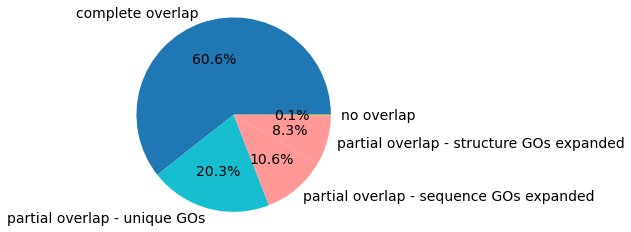

In [125]:
order = ['complete overlap', 'partial overlap - unique GOs',
         'partial overlap - sequence GOs expanded', 'partial overlap - structure GOs expanded',
         'no overlap']
vc = GOs['overlap'].value_counts()[order]
labels = vc.index
sizes = vc.values
colors = [color_reference[i] for i in labels]
# explode = (0.1, 0, 0, 0, 0)

fig, ax = plt.subplots()
piechart = ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, colors=colors, textprops={'fontsize': 14})
ax.axis('equal');

plt.savefig('/g/arendt/Fabian/PhD/Computational/Spongefold/coffe-paper/figures/GO_count.svg', bbox_inches="tight")

In 60.6 % of cases, all proteins that have GO-annotations from both structural and sequence similarity based annotations are overlapping 100 %. This is close to the number of proteins that share the same *most specific* orthogroup, which is not surprising. 
Another 39.2 % of all annotation pairs show at least partial overlap with 20.3 % of cases having unique GO terms on each side, 10.6 % of cases have additional GO terms on the sequence annotations side and 8.3 % of cases have additional GO terms in their strucure based annotation. Only in 0.1 % of cases (= 17 annotation pairs), the GO terms do not overlap whatsoever.

We then wondered how much the annotation pairs in the 'partial overlap' category actually differ from each other.

<AxesSubplot:xlabel='coverage_struct', ylabel='Count'>

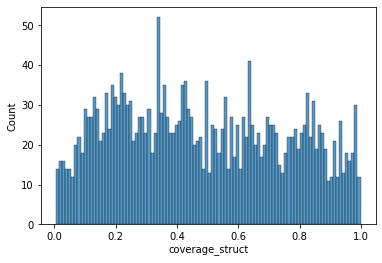

In [126]:
sns.histplot(GOs[GOs['overlap'] == 'partial overlap - unique GOs']['coverage_struct'], bins=100)

In [127]:
np.mean(GOs[GOs['overlap'] == 'partial overlap - unique GOs']['coverage_struct'])

0.4821899253270338

Within the 'partial overlap - unique GOs' category, stuctural GO terms on average contain around 50 % of the overlapping GO terms with a fairly uniform distribution between 0 and 100 %.

<AxesSubplot:xlabel='coverage_seq', ylabel='Count'>

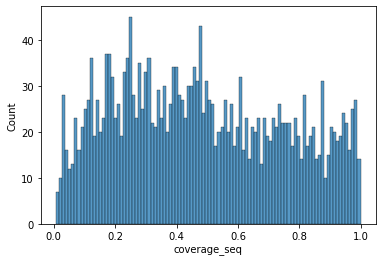

In [128]:
sns.histplot(GOs[GOs['overlap'] == 'partial overlap - unique GOs']['coverage_seq'], bins=100)

In [129]:
np.mean(GOs[GOs['overlap'] == 'partial overlap - unique GOs']['coverage_seq'])

0.48056632457400206

Within the 'partial overlap - unique GOs' category, sequence GO terms on average contain around 50 % of the overlapping GO terms. This is very similar to the strucutral GO terms.

<AxesSubplot:xlabel='coverage_seq', ylabel='Count'>

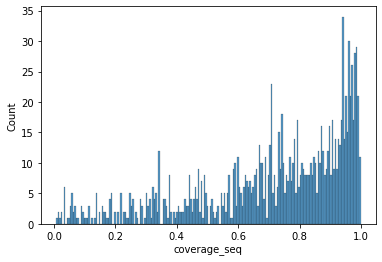

In [130]:
sns.histplot(GOs[GOs['overlap'] == 'partial overlap - sequence GOs expanded']['coverage_seq'], bins=200)

In [131]:
np.mean(GOs[GOs['overlap'] == 'partial overlap - sequence GOs expanded']['coverage_seq'])

0.7126174034458369

In the cases in which sequence annotations produce more GO terms (but have all structure GO terms included), the distribution shows that on average, structure GO terms make up around 70 % of the sequence GO terms.

<AxesSubplot:xlabel='coverage_struct', ylabel='Count'>

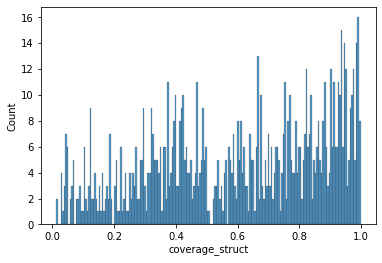

In [132]:
sns.histplot(GOs[GOs['overlap'] == 'partial overlap - structure GOs expanded']['coverage_struct'], bins=200)

In [133]:
np.mean(GOs[GOs['overlap'] == 'partial overlap - structure GOs expanded']['coverage_struct'])

0.6018304051791242

In the cases in which structure annotations produce more GO terms (but have all sequence GO terms included), the distribution shows that on average, sequence GO terms make up around 60 % of the sequence GO terms. Structure produced in these cases 40 % more GO terms. 

In this analysis, we solely compare the identifier and number of GO terms, however not their similarity. To compare the similarity of GO term annotations, we focus on semantic similarity of GO terms from annotations pairs in the 'partial overlap' category:

## GO term semantic similarity for partial GO term overlaps between structure and sequence based protein annotations

In [258]:
partial = (GOs['overlap'] == 'partial overlap - unique GOs') |( GOs['overlap'] == 'partial overlap - structure GOs expanded') | (GOs['overlap'] == 'partial overlap - sequence GOs expanded')

In [259]:
GOs_partial =  GOs[partial]

In [213]:
GOs_partial_unique = GOs_partial[GOs_partial['overlap'] == 'partial overlap - unique GOs']

### Check semantic similarity of GO terms of partial overlapping sequence-structure protein pairs with unique GO terms on both sides

Create a table that can be used as an input for GOGO (https://www.nature.com/articles/s41598-018-33219-y):

In [137]:
GOs_partial_unique_GOGO = GOs_partial_unique[['GOs_struct', 'GOs_seq']]

In [138]:
# iterate over each row and each column
for i, row in GOs_partial_unique_GOGO.iterrows():
    for col in GOs_partial_unique_GOGO.columns:
        # separate the elements in the list with a space
        GOs_partial_unique_GOGO.at[i, col] = " ".join(str(x) for x in row[col])
    # add the index of the row to the beginning of the list
    GOs_partial_unique_GOGO.at[i, 'GOs_struct'] = str(i) + "_struct" + " " + GOs_partial_unique_GOGO.at[i, 'GOs_struct']
    GOs_partial_unique_GOGO.at[i, 'GOs_seq'] = str(i) + "_seq" + " " + GOs_partial_unique_GOGO.at[i, 'GOs_seq']

# save the dataframe to a txt file without the header and index
GOs_partial_unique_GOGO.to_csv("/g/arendt/Fabian/PhD/Computational/Spongefold/GOGO_partial_unique_input.txt", sep=";", index=False, header=False)

I ran GOGO locally: `perl gene_pair_comb.pl ~/Desktop/GOGO_partial_unique_input.txt ~/Desktop/GOGO_partial_unique_input_result.txt`

In [139]:
GOGO_result_unique = pd.read_csv('/g/arendt/Fabian/PhD/Computational/Spongefold/GOGO_partial_unique_input_result.txt', sep=';', header=None)

In [140]:
GOGO_result_unique.rename(columns={0 :'GOs_struct', 1 :'GOs_seq'}, inplace=True)

In [141]:
GOGO_result_unique['GOs_struct'] = GOGO_result_unique['GOs_struct'].str.split(' ').str[1:]

In [142]:
GOGO_result_unique['GOs_seq'] = GOGO_result_unique['GOs_seq'].str.split(' ').str[1:]

In [143]:
# create a new column in the dataframe
GOGO_result_unique['BPO'] = None
GOGO_result_unique['CCO'] = None
GOGO_result_unique['MFO'] = None

# iterate over each row in the dataframe
for i, row in GOGO_result_unique.iterrows():
    # get the fifth last element of the list in col1
    # and store it in the new column
    GOGO_result_unique.at[i, 'BPO'] = row['GOs_seq'][-5]
    GOGO_result_unique.at[i, 'CCO'] = row['GOs_seq'][-3]
    GOGO_result_unique.at[i, 'MFO'] = row['GOs_seq'][-1]

In [144]:
GOGO_result_unique

GOs_struct  \
0                              [GO:0003674, GO:0005215]   
1     [GO:0001101, GO:0005575, GO:0005623, GO:000588...   
2     [GO:0003674, GO:0003824, GO:0004721, GO:000557...   
3     [GO:0001731, GO:0002181, GO:0002183, GO:000367...   
4     [GO:0003674, GO:0005215, GO:0005216, GO:000522...   
...                                                 ...   
2355  [GO:0000003, GO:0000302, GO:0001501, GO:000155...   
2356  [GO:0000228, GO:0000785, GO:0000790, GO:000557...   
2357  [GO:0000138, GO:0000139, GO:0000226, GO:000367...   
2358  [GO:0000323, GO:0000902, GO:0000904, GO:000367...   
2359  [GO:0000122, GO:0000149, GO:0000165, GO:000018...   

                                                GOs_seq    BPO    CCO    MFO  
0     [GO:0000166, GO:0003674, GO:0003676, GO:000372...     NA     NA  0.414  
1     [GO:0003674, GO:0003824, GO:0004721, GO:000472...  0.410  0.635     NA  
2     [GO:0000003, GO:0000079, GO:0000082, GO:000008...  0.598  0.704  0.820  
3     [GO:0001731, GO:0002181, GO:0002183, GO:000367...  0.872  0.822  0.897  
4     [GO:0003674, GO:0005215, GO:0005216, GO:000522...  0.759  0.869  0.961  
...                                                 ...    ...    ...    ...  
2355  [GO:0003674, GO:0005488, GO:0005515, GO:000554...  0.575  0.785  0.992  
2356  [GO:0000428, GO:0003674, GO:0003824, GO:000389...  0.425  0.889     NA  
2357  [GO:0000138, GO:0003674, GO:0005488, GO:000551...  0.552  0.923  1.000  
2358  [GO:0001501, GO:0001894, GO:0001932, GO:000193...  0.644  0.701  0.891  
2359  [GO:0001944, GO:0001945, GO:0001946, GO:000367...  0.665  0.851  0.825  

[2360 rows x 5 columns]

In [145]:
GOGO_result_unique_BPO = GOGO_result_unique['BPO'][GOGO_result_unique['BPO'] != 'NA'].astype('float')

<AxesSubplot:xlabel='BPO', ylabel='Count'>

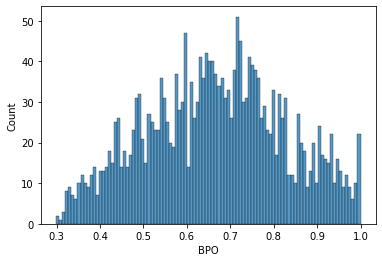

In [146]:
sns.histplot(GOGO_result_unique_BPO, bins=100)

In [147]:
np.mean(GOGO_result_unique_BPO)

0.6656481398476022

<AxesSubplot:xlabel='CCO', ylabel='Count'>

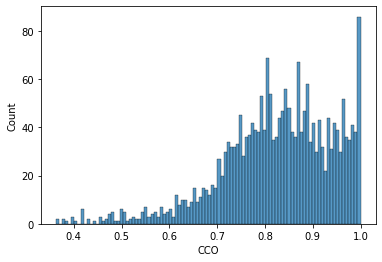

In [148]:
GOGO_result_unique_CCO = GOGO_result_unique['CCO'][GOGO_result_unique['CCO'] != 'NA'].astype('float')
sns.histplot(GOGO_result_unique_CCO, bins=100)

In [149]:
np.mean(GOGO_result_unique_CCO)

0.8254611161939618

<AxesSubplot:xlabel='MFO', ylabel='Count'>

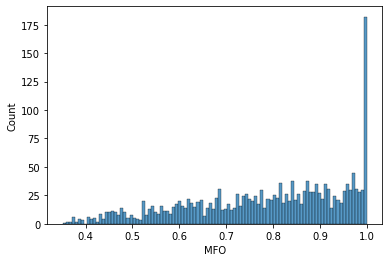

In [150]:
GOGO_result_unique_MFO = GOGO_result_unique['MFO'][GOGO_result_unique['MFO'] != 'NA'].astype('float')
sns.histplot(GOGO_result_unique_MFO, bins=100)

In [151]:
np.mean(GOGO_result_unique_MFO)

0.7859392819429791

### Check semantic similarity of GO terms of partial overlapping sequence-structure protein pairs with additional GO terms on either side

In [152]:
GOs_partial_expanded = GOs_partial[GOs_partial['overlap'] != 'partial overlap - unique GOs']

In [153]:
GOs_partial_expanded

GOs_struct  \
11     [GO:0000166, GO:0000323, GO:0001882, GO:000188...   
12     [GO:0003674, GO:0004857, GO:0005095, GO:000548...   
21     [GO:0000166, GO:0001501, GO:0001503, GO:000150...   
35     [GO:0000122, GO:0000166, GO:0000228, GO:000078...   
66     [GO:0003674, GO:0003824, GO:0004364, GO:000548...   
...                                                  ...   
41924  [GO:0000278, GO:0001726, GO:0002090, GO:000209...   
41925  [GO:0000049, GO:0000166, GO:0001514, GO:000188...   
41931  [GO:0000775, GO:0003674, GO:0005488, GO:000551...   
41936  [GO:0000003, GO:0000165, GO:0000166, GO:000156...   
41942  [GO:0000151, GO:0000209, GO:0000226, GO:000367...   

                                                 GOs_seq  \
11     [GO:0005575, GO:0005622, GO:0005623, GO:000573...   
12     [GO:0002376, GO:0002520, GO:0003674, GO:000485...   
21     [GO:0000041, GO:0000166, GO:0001501, GO:000150...   
35     [GO:0000122, GO:0000166, GO:0000228, GO:000078...   
66     [GO:0001101, GO:0001885, GO:0002064, GO:000315...   
...                                                  ...   
41924  [GO:0000278, GO:0001726, GO:0002090, GO:000209...   
41925  [GO:0001514, GO:0003674, GO:0003676, GO:000372...   
41931  [GO:0000775, GO:0003674, GO:0005488, GO:000551...   
41936  [GO:0000003, GO:0000165, GO:0001654, GO:000170...   
41942  [GO:0000151, GO:0000209, GO:0003674, GO:000382...   

                                        overlap  coverage_struct  coverage_seq  
11     partial overlap - structure GOs expanded         0.183246      1.000000  
12      partial overlap - sequence GOs expanded         1.000000      0.742424  
21      partial overlap - sequence GOs expanded         1.000000      0.896000  
35      partial overlap - sequence GOs expanded         1.000000      0.969112  
66      partial overlap - sequence GOs expanded         1.000000      0.675159  
...                                         ...              ...           ...  
41924   partial overlap - sequence GOs expanded         1.000000      0.825397  
41925  partial overlap - structure GOs expanded         0.729167      1.000000  
41931  partial overlap - structure GOs expanded         0.944785      1.000000  
41936  partial overlap - structure GOs expanded         0.386813      1.000000  
41942  partial overlap - structure GOs expanded         0.795918      1.000000  

[2203 rows x 5 columns]

Create a table that can be used as an input for GOGO (https://www.nature.com/articles/s41598-018-33219-y):

In [154]:
GOs_partial_expanded_GOGO = GOs_partial_expanded[['GOs_struct', 'GOs_seq']]

In [155]:
# iterate over each row and each column
for i, row in GOs_partial_expanded_GOGO.iterrows():
    for col in GOs_partial_expanded_GOGO.columns:
        # separate the elements in the list with a space
        GOs_partial_expanded_GOGO.at[i, col] = " ".join(str(x) for x in row[col])
    # add the index of the row to the beginning of the list
    GOs_partial_expanded_GOGO.at[i, 'GOs_struct'] = str(i) + "_struct" + " " + GOs_partial_expanded_GOGO.at[i, 'GOs_struct']
    GOs_partial_expanded_GOGO.at[i, 'GOs_seq'] = str(i) + "_seq" + " " + GOs_partial_expanded_GOGO.at[i, 'GOs_seq']

# save the dataframe to a txt file without the header and index
GOs_partial_expanded_GOGO.to_csv("/g/arendt/Fabian/PhD/Computational/Spongefold/GOGO_partial_expanded_input.txt", sep=";", index=False, header=False)

I ran GOGO locally: `perl gene_pair_comb.pl ~/Desktop/GOGO_partial_expanded_input.txt ~/Desktop/GOGO_partial_expanded_input_result.txt`

In [156]:
GOGO_result_expanded = pd.read_csv('/g/arendt/Fabian/PhD/Computational/Spongefold/GOGO_partial_expanded_input_result.txt', sep=';', header=None)

In [157]:
GOGO_result_expanded.rename(columns={0 :'GOs_struct', 1 :'GOs_seq'}, inplace=True)

In [158]:
GOGO_result_expanded['GOs_struct'] = GOGO_result_expanded['GOs_struct'].str.split(' ').str[1:]

In [159]:
GOGO_result_expanded['GOs_seq'] = GOGO_result_expanded['GOs_seq'].str.split(' ').str[1:]

In [160]:
# create a new column in the dataframe
GOGO_result_expanded['BPO'] = None
GOGO_result_expanded['CCO'] = None
GOGO_result_expanded['MFO'] = None

# iterate over each row in the dataframe
for i, row in GOGO_result_expanded.iterrows():
    # get the fifth last element of the list in col1
    # and store it in the new column
    GOGO_result_expanded.at[i, 'BPO'] = row['GOs_seq'][-5]
    GOGO_result_expanded.at[i, 'CCO'] = row['GOs_seq'][-3]
    GOGO_result_expanded.at[i, 'MFO'] = row['GOs_seq'][-1]

In [161]:
GOGO_result_expanded

GOs_struct  \
0     [GO:0000166, GO:0000323, GO:0001882, GO:000188...   
1     [GO:0003674, GO:0004857, GO:0005095, GO:000548...   
2     [GO:0000166, GO:0001501, GO:0001503, GO:000150...   
3     [GO:0000122, GO:0000166, GO:0000228, GO:000078...   
4     [GO:0003674, GO:0003824, GO:0004364, GO:000548...   
...                                                 ...   
2198  [GO:0000278, GO:0001726, GO:0002090, GO:000209...   
2199  [GO:0000049, GO:0000166, GO:0001514, GO:000188...   
2200  [GO:0000775, GO:0003674, GO:0005488, GO:000551...   
2201  [GO:0000003, GO:0000165, GO:0000166, GO:000156...   
2202  [GO:0000151, GO:0000209, GO:0000226, GO:000367...   

                                                GOs_seq    BPO    CCO    MFO  
0     [GO:0005575, GO:0005622, GO:0005623, GO:000573...  0.594  0.829     NA  
1     [GO:0002376, GO:0002520, GO:0003674, GO:000485...  0.888  0.942  1.000  
2     [GO:0000041, GO:0000166, GO:0001501, GO:000150...  0.981  0.966  0.993  
3     [GO:0000122, GO:0000166, GO:0000228, GO:000078...  0.990  1.000  1.000  
4     [GO:0001101, GO:0001885, GO:0002064, GO:000315...  0.920  0.887  0.930  
...                                                 ...    ...    ...    ...  
2198  [GO:0000278, GO:0001726, GO:0002090, GO:000209...  0.951  0.968  1.000  
2199  [GO:0001514, GO:0003674, GO:0003676, GO:000372...  1.000  0.903  0.808  
2200  [GO:0000775, GO:0003674, GO:0005488, GO:000551...  0.999  0.968  1.000  
2201  [GO:0000003, GO:0000165, GO:0001654, GO:000170...  0.823  0.721  0.704  
2202  [GO:0000151, GO:0000209, GO:0003674, GO:000382...  0.974  0.827  0.988  

[2203 rows x 5 columns]

In [162]:
GOGO_result_expanded_BPO = GOGO_result_expanded['BPO'][GOGO_result_expanded['BPO'] != 'NA'].astype('float')

<AxesSubplot:xlabel='BPO', ylabel='Count'>

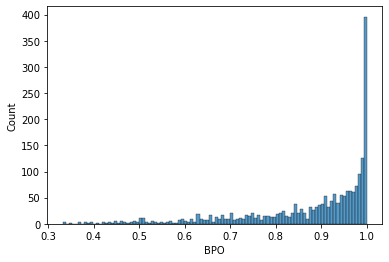

In [163]:
sns.histplot(GOGO_result_expanded_BPO, bins=100)

In [164]:
np.mean(GOGO_result_expanded_BPO)

0.8768518696069056

<AxesSubplot:xlabel='CCO', ylabel='Count'>

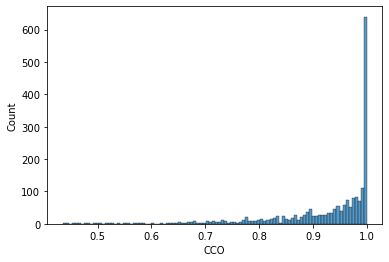

In [165]:
GOGO_result_expanded_CCO = GOGO_result_expanded['CCO'][GOGO_result_expanded['CCO'] != 'NA'].astype('float')
sns.histplot(GOGO_result_expanded_CCO, bins=100)

In [166]:
np.mean(GOGO_result_expanded_CCO)

0.9267089588377744

<AxesSubplot:xlabel='MFO', ylabel='Count'>

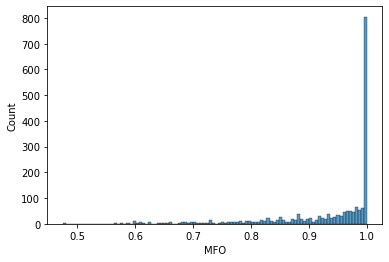

In [167]:
GOGO_result_expanded_MFO = GOGO_result_expanded['MFO'][GOGO_result_expanded['MFO'] != 'NA'].astype('float')
sns.histplot(GOGO_result_expanded_MFO, bins=100)

In [168]:
np.mean(GOGO_result_expanded_MFO)

0.9309306777030519

### Create a summary of the GO term semantic similarity results:

In [169]:
GOGO_result_unique_results = GOGO_result_unique[['BPO', 'CCO', 'MFO']]

In [170]:
GOGO_result_unique_results_long = GOGO_result_unique_results.melt(value_vars=['BPO', 'CCO', 'MFO'], var_name = 'GO ontology')
GOGO_result_unique_results_long = GOGO_result_unique_results_long[GOGO_result_unique_results_long['value'] != 'NA']
GOGO_result_unique_results_long['value'] = GOGO_result_unique_results_long['value'].astype('float')
GOGO_result_unique_results_long['category'] = 'unique GOs'

In [171]:
GOGO_result_expanded_results = GOGO_result_expanded[['BPO', 'CCO', 'MFO']]

In [172]:
GOGO_result_expanded_results_long = GOGO_result_expanded_results.melt(value_vars=['BPO', 'CCO', 'MFO'], var_name = 'GO ontology')
GOGO_result_expanded_results_long = GOGO_result_expanded_results_long[GOGO_result_expanded_results_long['value'] != 'NA']
GOGO_result_expanded_results_long['value'] = GOGO_result_expanded_results_long['value'].astype('float')
GOGO_result_expanded_results_long['category'] = 'GOs expanded'

In [173]:
GOGO_results_long_combined = GOGO_result_expanded_results_long.append(GOGO_result_unique_results_long)

In [174]:
color_reference = {
    'unique GOs': cm.tab20.colors[18],
    'GOs expanded': cm.tab20.colors[7]
}

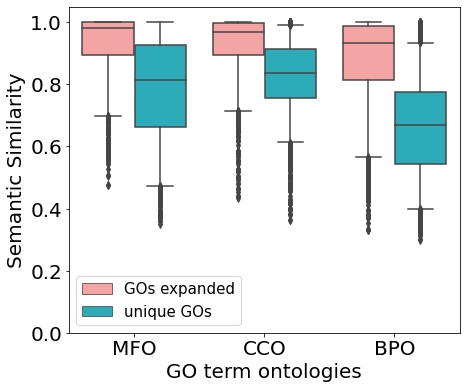

In [175]:
f, ax = plt.subplots(figsize=(7, 6))

sns.boxplot(data=GOGO_results_long_combined, y='value', x='GO ontology', hue='category', order=['MFO', 'CCO', 'BPO'], whis=[5, 95], palette=color_reference)
ax.set(ylim=(0, 1.05))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlabel('GO term ontologies', size=20)
ax.set_ylabel('Semantic Similarity',size=20)

plt.legend(title = '', fontsize=15)

plt.savefig('/g/arendt/Fabian/PhD/Computational/Spongefold/coffe-paper/figures/GO_semantic_similarities.svg', bbox_inches="tight")

## GO depth analysis and comparison

As a last measure, we would love to compare GO term depths in the partially overlapping GO term categories. This is the plan:

    1. Make new column with overlap between GO term assignments from sequence- and structure based annotations from the partial overlap category
    2. Assign GO term depths for each GO term within each GO ontology using GOATOOLS (https://www.nature.com/articles/s41598-018-28948-z)
    3. Return maxiumum GO depths within each GO ontology
    4. Plot
    
    
This will answer the question: "How deep did the common annotation between sequence- and structure based annotation go in each of the GO ontologies?

In [260]:
GOs_partial['overlap_GOs'] = ''

for index, row in GOs_partial.iterrows():
    lst1 = row['GOs_struct']
    lst2 = row['GOs_seq']
    GOs_partial.at[index, 'overlap_GOs'] = list(set(lst1) & set(lst2))

/tmp/ipykernel_125/2522461405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOs_partial['overlap_GOs'] = ''


In [74]:
fin_obo   = '/g/arendt/Fabian/PhD/Computational/spongeprot/data/GO_analysis/go-basic.obo'             # DAG containing HPO terms

In [188]:
from goatools.obo_parser import GODag

obodag = GODag(fin_obo, load_obsolete=True)

/g/arendt/Fabian/PhD/Computational/spongeprot/data/GO_analysis/go-basic.obo: fmt(1.2) rel(2022-07-01) 50,918 Terms


In [281]:
GOs_partial['MFO_max_depth'] = ''
GOs_partial['CCO_max_depth'] = ''
GOs_partial['BPO_max_depth'] = ''

for index, row in GOs_partial.iterrows():
    MFO_max_depth = []
    CCO_max_depth = []
    BPO_max_depth = []
    for GO in row['overlap_GOs']:
        if obodag[GO].namespace == 'molecular_function':
            MFO_max_depth.append(obodag[GO].depth)
        elif obodag[GO].namespace == 'cellular_component':
            CCO_max_depth.append(obodag[GO].depth)
        elif obodag[GO].namespace == 'biological_process':
            BPO_max_depth.append(obodag[GO].depth)
        else: print('something is wrong')
        GOs_partial.at[index, 'MFO_max_depth'] = MFO_max_depth
        GOs_partial.at[index, 'CCO_max_depth'] = CCO_max_depth
        GOs_partial.at[index, 'BPO_max_depth'] = BPO_max_depth
    GOs_partial.at[index, 'MFO_max_depth'] = max(GOs_partial.at[index, 'MFO_max_depth'], default=None)
    GOs_partial.at[index, 'CCO_max_depth'] = max(GOs_partial.at[index, 'CCO_max_depth'], default=None)
    GOs_partial.at[index, 'BPO_max_depth'] = max(GOs_partial.at[index, 'BPO_max_depth'], default=None)

/tmp/ipykernel_125/2065038866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOs_partial['MFO_max_depth'] = ''
/tmp/ipykernel_125/2065038866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GOs_partial['CCO_max_depth'] = ''
/tmp/ipykernel_125/2065038866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Format dataframe for plotting

In [285]:
GO_depth_plotting = GOs_partial[['overlap', 'MFO_max_depth', 'CCO_max_depth', 'BPO_max_depth']]

In [288]:
GO_depth_plotting_long = GO_depth_plotting.melt(id_vars='overlap', var_name='ontology')

In [300]:
GO_depth_plotting_long = GO_depth_plotting_long[~GO_depth_plotting_long['value'].isnull()]

In [317]:
GO_depth_plotting_long['overlap_condensed'] = ''

for index, row in GO_depth_plotting_long.iterrows():
    if row['overlap'] == 'partial overlap - unique GOs':
        GO_depth_plotting_long.at[index, 'overlap_condensed'] = 'unique GOs'
    else: GO_depth_plotting_long.at[index, 'overlap_condensed'] = 'GOs expanded'

/tmp/ipykernel_125/1019678659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_depth_plotting_long['overlap_condensed'] = ''


In [320]:
color_reference = {
    'unique GOs': cm.tab20.colors[18],
    'GOs expanded': cm.tab20.colors[7]
}

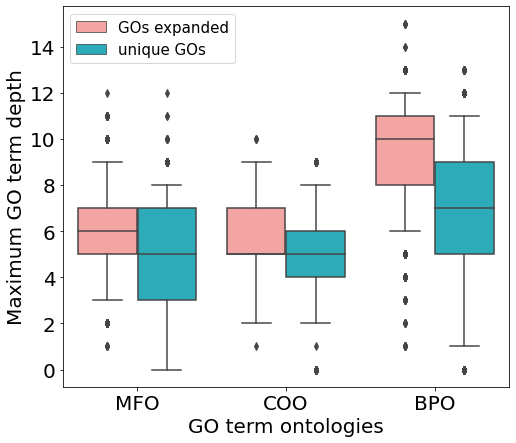

In [329]:
ontologies = ['MFO', 'COO', 'BPO']

f, ax = plt.subplots(figsize=(8, 7))

sns.boxplot(data=GO_depth_plotting_long, y='value', x='ontology', hue='overlap_condensed', hue_order=['GOs expanded', 'unique GOs'] , whis=[5, 95], palette=color_reference)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xticklabels(ontologies, size=20)

ax.set_xlabel('GO term ontologies', size=20)
ax.set_ylabel('Maximum GO term depth',size=20)

plt.legend(title = '', fontsize=15)

plt.savefig('/g/arendt/Fabian/PhD/Computational/Spongefold/coffe-paper/figures/GO_depth.svg', bbox_inches="tight")

Here we go. In general however, it is difficult to interpret and compare GO depths. Similar GO depths can specify very different levels of details in different branches of the hierarchy.